In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [2]:
'''
Load data
'''
# 94 行的Korea, South 手動更改為Korea South
data = np.loadtxt("covid_19.csv",dtype=np.str,delimiter=',')
data = np.delete(data, [0,1,2], 0)
data = np.delete(data, [1,2], 1)
countries = data[:,0]
data = np.delete(data, [0], 1)
print(data.shape) #185 countries,  82days
print(data[0])
data

(185, 82)
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '4' '4' '5' '7' '7' '7' '11' '16'
 '21' '22' '22' '22' '24' '24' '40' '40' '74' '84' '94' '110' '110' '120'
 '170' '174' '237' '273' '281' '299' '349' '367' '423' '444' '484' '521'
 '555' '607']


array([['0', '0', '0', ..., '521', '555', '607'],
       ['0', '0', '0', ..., '416', '433', '446'],
       ['0', '0', '0', ..., '1761', '1825', '1914'],
       ...,
       ['0', '0', '0', ..., '1', '1', '1'],
       ['0', '0', '0', ..., '40', '40', '43'],
       ['0', '0', '0', ..., '13', '14', '14']], dtype='<U32')

In [7]:
diff_data = data.astype(int)
# 計算差值 共有81個差值
for i in range(data.shape[0]):
    for j in range(1,data.shape[1]):
        diff_data[i][j] = data[i][j].astype(int) - data[i][j-1].astype(int)
print(diff_data.shape)
diff_data[0]

(185, 82)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1,  2,  0,
        0,  4,  5,  5,  1,  0,  0,  2,  0, 16,  0, 34, 10, 10, 16,  0, 10,
       50,  4, 63, 36,  8, 18, 50, 18, 56, 21, 40, 37, 34, 52])

In [8]:
diff_data = diff_data[:,1:] # 只有81個插值
print(diff_data.shape)

(185, 81)


In [9]:
'''
Correlation coefficient matrix
'''
corrcoef_matrix = np.zeros((len(countries),len(countries)))

for i in range(len(countries)):
    for j in range(len(countries)):
        c1 = diff_data[i].astype(int)
        c2 = diff_data[j].astype(int)
        
        corrcoef_matrix[j][i] = np.corrcoef(c1,c2)[0][1]

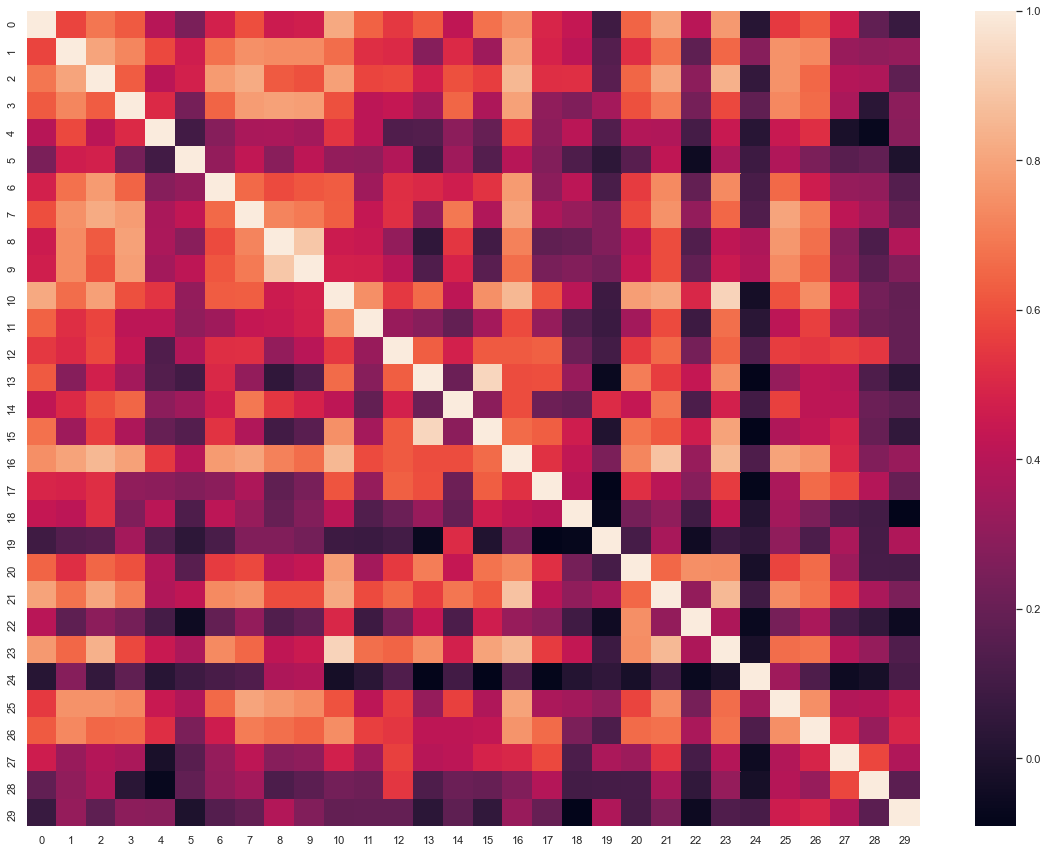

In [11]:
sns.set()
plt.subplots(figsize=(20,15))
sns.heatmap(corrcoef_matrix[:30,:30])

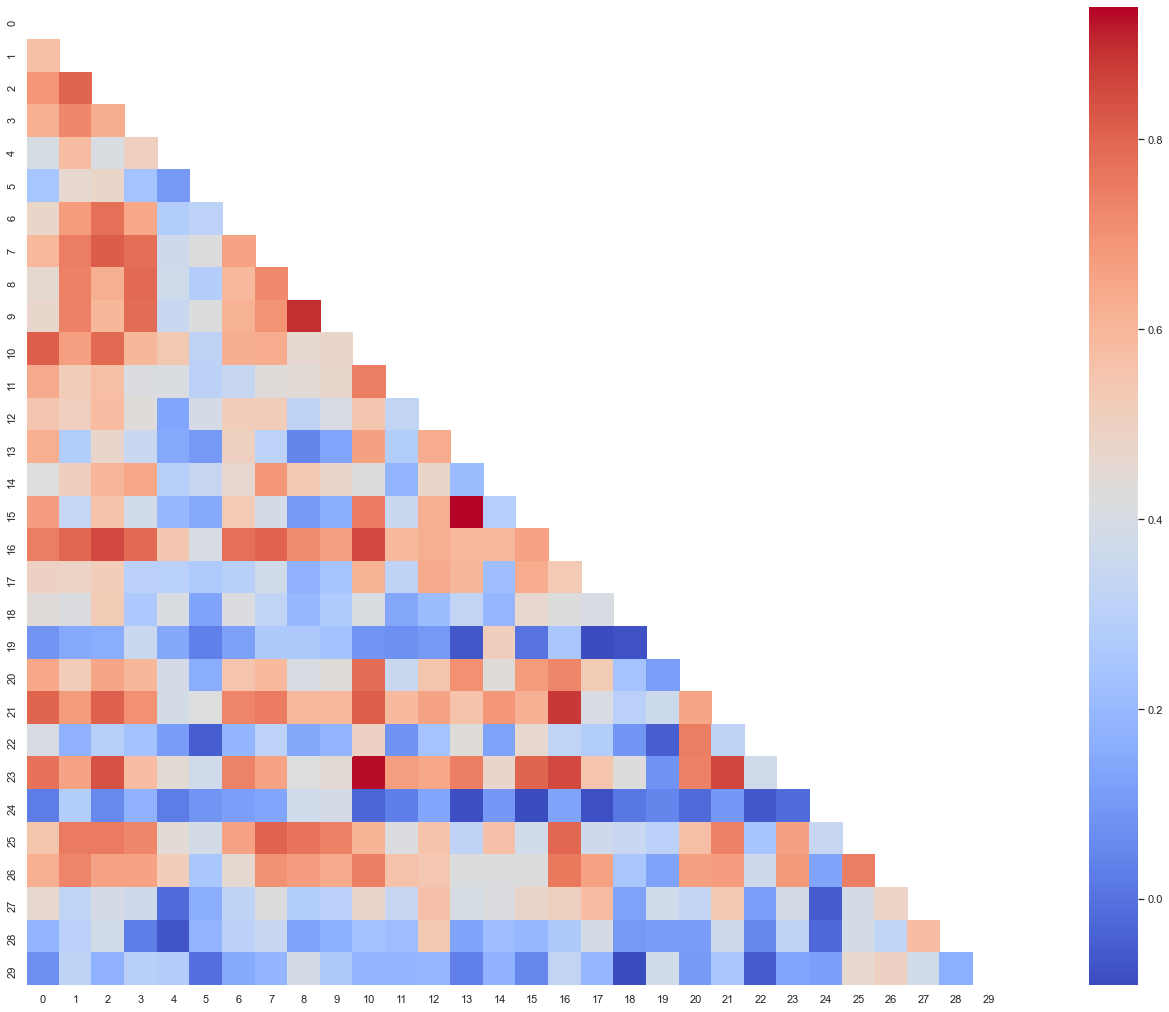

In [12]:
mask = np.zeros_like(corrcoef_matrix[:30,:30])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30,18))
    ax = sns.heatmap(corrcoef_matrix[:30,:30], mask=mask, square=True, cmap="coolwarm")

In [14]:
threshold = .85
# 0.70 -> ,0.75 -> ,0.80 -> ,0.85 -> 84,0.90 -> 
length = len(corrcoef_matrix)
country_list = []
for i in range(length):
    for j in range(length):
        if abs(corrcoef_matrix[i][j]) > threshold and i != j:
            country_list.append(i)
            country_list.append(j)
# len(country_list)
C = np.unique(country_list)
len(C), C # 符合threshold的國家

(84,
 array([  1,   2,   7,   8,   9,  10,  13,  15,  16,  21,  23,  25,  32,
         35,  37,  40,  42,  43,  44,  45,  46,  50,  51,  52,  53,  60,
         64,  65,  67,  69,  70,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  86,  88,  92,  95, 100, 101, 105, 111, 112, 116, 120, 121,
        123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137,
        138, 145, 146, 147, 150, 152, 153, 156, 160, 161, 165, 169, 170,
        171, 173, 174, 175, 177, 182]))

In [33]:
'''Generate sequence data'''

L = 7 # interval
print("差值 data shape:", diff_data[C].shape)

C_data = diff_data[C]
seqData, seqLabel = [], []

for i in range(C_data.shape[0]): # 84個國家
    for j in range(C_data.shape[1]-(L)): # 81-5=76 
        x = C_data[i] # i th country
        seqData.append(x[j:j+L].astype(int)) # 會少了最後一個 因為沒有index=81
        seqLabel.append(1 if x[j+L]>x[j+L-1] else 0)

len(seqData), len(seqLabel) # 

差值 data shape: (84, 81)


(6216, 6216)

In [89]:
'''取得不重複的資料：1)確保不重複 2) 確保同資料不會有不同label'''

# 先觀察不重複的資料有多長
uni_list = np.unique(seqData, axis=0)
print("Unique values:", len(uni_list)) # length

# 取得不重複資料以及其label(以第一個的label為主)
seen = set()
unique_seqData = []
unique_seqLabel = []
for i in range(len(seqData)):
    t = tuple(seqData[i])
    if t not in seen:
        unique_seqData.append(seqData[i])
        unique_seqLabel.append(seqLabel[i])
        seen.add(t)
print(len(unique_seqData),len(unique_seqLabel))

3253 3253


In [94]:
# C_data.shape[1]-(L) # 74

In [95]:
data = torch.Tensor(unique_seqData)
label = torch.Tensor(unique_seqLabel)

print("data:",data.shape," label:",label.shape)
# data, label # seqData, seqLabel as Tensor

data: torch.Size([3253, 7])  label: torch.Size([3253])


In [112]:
'''train test split'''

split_ratio = 0.8
trainData = data[:int(len(data)*split_ratio)]
testData = data[int(len(data)*split_ratio):]
trainLabel = label[:int(len(label)*split_ratio)]
testLabel = label[int(len(label)*split_ratio):]
print("train length:",len(trainData),", test length:",len(testData))

train length: 2602 , test length: 651


In [118]:
input_size = 1 # input 每次的特徵數
seq_length = L # 看幾天 即interval
hidden_size = 64 # 自定義RNN hidden nodes
number_of_layers = 1 # 幾層RNN
batchsize = 16 # 看過幾個資料後更新
epochs = 300 # 訓練整個資料幾次
learning_rate = 0.001 # learning rate

'''
dataset
'''
train_dataset = Data.TensorDataset(trainData,trainLabel) # 轉成torch能夠識別的dataset
test_dataset = Data.TensorDataset(testData,testLabel)

'''
data loader
'''
# 把train dataset放到dataloader裡
loader = Data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=batchsize,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    # num_workers=2,              # 多线程来读数据
)

In [119]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(# if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=64,# rnn hidden unit
            num_layers=1,# number of rnn layer
            batch_first=True,
            # input & output will has batch size as 1s dimension. 
            # e.g. (batch, time_step, input_size) 
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        # x shape (batch, time_step, input_size) input x的shape
        # r_out shape (batch, time_step, output_size) output的形狀
        # 會產生兩個hidden state
        # h_n shape (n_layers, batch, hidden_size) 
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :]) # 選取看完第五個以後的output (只取最後一個hidden output)
        final = self.sigmoid(out)
        return final

In [127]:
rnn = RNN()
# print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
loss_func = nn.BCELoss() 
print(rnn)

RNN(
  (rnn): LSTM(1, 64, batch_first=True)
  (sigmoid): Sigmoid()
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [128]:
# for step, (x, y) in enumerate(loader):
#     print(step, x.shape, y.shape)

In [129]:
loss_record = []
acc_record = []

for epoch in range(epochs):   # 训练所有!整套!数据 3 次
    train_loss = 0
    test_acc = 0
    train_acc = 0
    test_acc = 0
    print("Starting no.",epoch," epoch......")

    for step, (x, y) in enumerate(loader):  # mini-batch learning
        # print(x.shape)
        numofdata = int(x.shape[0]*x.shape[1] / seq_length)
        batch_x = Variable(x.view(numofdata, seq_length, input_size)) 
        # reshape x to (batch, time_step, input_size)
        batch_y = Variable(y)# batch y
        
        output = rnn(batch_x) # rnn output
        loss = loss_func(output, batch_y) # cross entropy loss
        optimizer.zero_grad() # clear gradients for this training step
        loss.backward() # backpropagation, compute gradients
        optimizer.step() # apply gradients

        if step % 100 == 0:
            # training
            train_output = rnn(Variable(trainData.view(trainData.shape[0], seq_length, input_size))) 
            pred_y = torch.max(train_output, 1)[1].data.numpy().squeeze()
            train_acc = (np.sum(np.absolute(pred_y-np.array(trainLabel)))) / len(pred_y)

            # testing
            test_output = rnn(Variable(testData.view(testData.shape[0], seq_length, input_size))) # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            test_acc = (np.sum(np.absolute(pred_y-np.array(testLabel)))) / len(pred_y)

            print('Epoch: ', epoch, '| Step: ', step, '| train loss: %.4f' % loss)
            print('Training accuracy: %.5f' % train_acc)
            print('Testing accuracy: %.5f' % test_acc)
        
        
            # how to get loss?
        # print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
            #   batch_x.numpy(), '| batch y: ', batch_y.numpy())

acy: 0.52688
Epoch:  211 | Step:  100 | train loss: 0.2556
Training accuracy: 0.52306
Testing accuracy: 0.52688
Starting no. 212  epoch......
Epoch:  212 | Step:  0 | train loss: 0.2501
Training accuracy: 0.52306
Testing accuracy: 0.52688
Epoch:  212 | Step:  100 | train loss: 0.3584
Training accuracy: 0.52306
Testing accuracy: 0.52688
Starting no. 213  epoch......
Epoch:  213 | Step:  0 | train loss: 0.1991
Training accuracy: 0.52306
Testing accuracy: 0.52688
Epoch:  213 | Step:  100 | train loss: 0.1612
Training accuracy: 0.52306
Testing accuracy: 0.52688
Starting no. 214  epoch......
Epoch:  214 | Step:  0 | train loss: 0.1605
Training accuracy: 0.52306
Testing accuracy: 0.52688
Epoch:  214 | Step:  100 | train loss: 0.2278
Training accuracy: 0.52306
Testing accuracy: 0.52688
Starting no. 215  epoch......
Epoch:  215 | Step:  0 | train loss: 0.2913
Training accuracy: 0.52306
Testing accuracy: 0.52688
Epoch:  215 | Step:  100 | train loss: 0.1609
Training accuracy: 0.52306
Testing ac

In [94]:
np.sum(np.absolute(pred_y-np.array(y)))
# 1-0
# 1-1
# 0-1
# 0-0

2953.0

In [133]:
import pygal
from pygal.maps.world import World

In [151]:
print(C_data.shape) # 84國家 81個差值
wmData = C_data[:,-L:]
wmData.shape

(84, 81)


(84, 7)

In [142]:
wm_pred = rnn(Variable(testData.view(testData.shape[0], seq_length, input_size)))
print(type(wm_pred.detach().numpy()))
wm_pred_np = wm_pred.detach().numpy()
wm_pred_np.shape, len(testData)

((651, 1), 651)

In [143]:
# 取最後L=7天作為input
ascent = []
descent = []
for i in range(len(wm_pred_np)):



array([0.00239508], dtype=float32)

In [134]:
worldmap_chart = pygal.maps.world.World()
worldmap_chart.title = 'Minimum deaths by capital punishement (source: Amnesty International)'
worldmap_chart.add('In 2012', {
  'af': 14,
  'bd': 1,
  'by': 3,
  'cn': 1000,
  'gm': 9,
  'in': 1,
  'ir': 314,
  'iq': 129,
  'jp': 7,
  'kp': 6,
  'pk': 1,
  'ps': 6,
  'sa': 79,
  'so': 6,
  'sd': 5,
  'tw': 6,
  'ae': 1,
  'us': 43,
  'ye': 28
})
worldmap_chart.render()
worldmap_chart.render_to_file('map.svg')

In [ ]:
# 下面是垃圾

In [21]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 5
# Number of features in last hidden state ie. number of output time-
# steps to predict.See image below for more clarity.
HIDDEN_SIZE = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1
# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1
# row. Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

In [ ]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

In [ ]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)